# Supply Chain 101 revisited with Modern Bayesian Techniques (Draft Outline)

Companies want to have stock on hand to sell you, but they don't want to buy stuff they won't sell. How do you figure out how much to hold a buy?

To know how much we need to order, and when, we need use a basic formula
* Daily_Demand * Lead Time in days

So for example if you sell ten boxes of cereal a day, and it takes 3 days for orders to arrive from the cereal fatory, then you should hold 30 boxes of cereal on hand or you'll run out as people buy their breakfast.

This is great except in real life, both demand and supply are not constant. 
In most textbook this is either given, or done through point estimates. With Pymc3 we can do way better

## The rocket analogy
The PyMC3 team runs a rocket factory, and rockets need bolts! The demand for bolts is stochastic, after all we're not sure hwen people need rockets exactly. The supply for bolts is also stochastic, trucks get delayed, people get busy, things happen. But the PyMC team needs to keep those rockets coming. If they want to ensure that we're able to build rockets with at least a 95% service level, how many bolts should be left on the shelf before the PyMC3 team puts in an order for more bolts?

### The steps we'll take
1. Estimate lead time distribution parameters, and demand per day distribution parameters using Pymc3
2. Construct Posterior Predictive Samples for possible lead times and possible demand per day using PyMC3
3. Randomly draw a lead time sample from lead time posterior predictive samples.
4. Randomly draw N demand samples from demand posterior predictive check, where N=lead time sample

## Step 1: Collect Data
Data in supply chains usually is just transactions in a SQL Database. These need to be converted into distributions for Pymc3

In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
np.random.seed(0)

In [2]:
# This usually needs to be calculated as well
supplier_leadtime_days = np.repeat([2,4,2,3,2,2,3], 20)*10
demand_per_day = np.repeat([2,4,2,3,2,2,3], 10)

## Step 2: Estimate Distributions
Good thing we have Bayesian Magic.

Poisson is a good choice because it only exists over domain of positive natural numbers. Demand rarely is fractional (depends on industry and product though). Lead time is usually planned in days between suppliers. 

In [3]:
with pm.Model() as supplier_lead_time:
    # Just guessing on the priors
    _lambda = pm.Normal("lambda", mu=10, sd=2)
    lead_time = pm.Poisson("lead_time", mu=_lambda, observed = supplier_leadtime_days)
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior, samples=1000)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4055' (I am process '4114')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
100%|██████████| 1000/1000 [00:00<00:00, 2626.82it/s]


In [4]:
lead_time_data = az.from_pymc3(
        trace=posterior,
        posterior_predictive=posterior_pred
        )

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c28e48e10>],
      dtype=object)

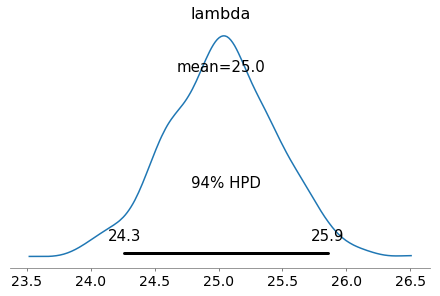

In [5]:
az.plot_posterior(lead_time_data)

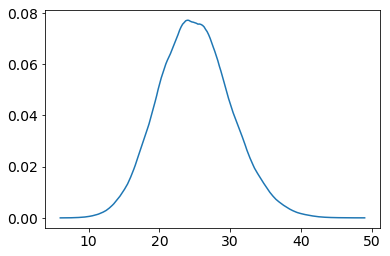

In [6]:
az.plot_kde(lead_time_data.posterior_predictive.to_array())

### Also estimate demand distribution
Unit demand needs to be characterized as well

In [7]:
with pm.Model() as demand_model:
    # Just guessing on the priors
    _lambda = pm.Normal("lambda", mu=10, sd=2)
    lead_time = pm.Poisson("lead_time", mu=_lambda, observed = demand_per_day)
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior, samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda]
100%|██████████| 1000/1000 [00:00<00:00, 2405.67it/s]


In [8]:
demand_data = az.from_pymc3(
        trace=posterior,
        posterior_predictive=posterior_pred
        )

In [9]:
posterior_pred

defaultdict(list, {'lead_time': array([[4, 3, 4, ..., 4, 5, 2],
                    [1, 5, 1, ..., 2, 3, 3],
                    [4, 1, 3, ..., 0, 2, 6],
                    ...,
                    [1, 0, 2, ..., 1, 5, 3],
                    [3, 2, 4, ..., 4, 1, 4],
                    [3, 0, 4, ..., 3, 1, 1]])})

## Step 3: Using two distributions, generate demand over supply lead time distribution
Procedure
1. Take random sample from LT Distribution to achieve lead_time_days
2. Take N samples from demand distribution, where N=lead_time_days
3. Add sample to demand_over_lt  sample
4. Repeat until you have large sample set

Now a choice
Use non parameteric to determine 95% distribution bounds, or use Pymc3 to estimate distribution parameters

This is already way better than what most supply chains do so doesn't have to be perfectb

In [10]:
demand_during_lt = []
for _ in range(1000):
    # Get Supply Chain LT
    supply_lt = np.random.choice(lead_time_data.posterior_predictive.to_array().values.flatten())
    demand_during_days = np.random.choice(demand_data.posterior_predictive.to_array().values.flatten(), size = supply_lt)
    demand_during_lt.append(np.sum(demand_during_days))
        

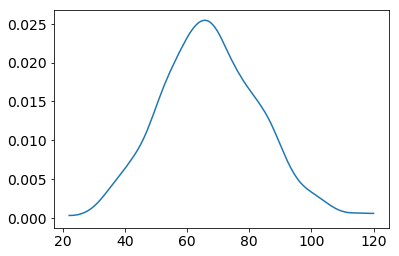

In [11]:
az.plot_kde(demand_during_lt)

In [12]:
# 95th percentile service level assuming zero inventory in stock
np.percentile(demand_during_lt, q=95)

94.0

## Conclusion
Based off of this analysis an order should be placed when inventory levels reach 94 units to maintain a 95% service level. Or  in other words at 94 units of inventory, if no order is open, there is a 5% chance you will not be able to meet demand.

## Extending this
1. Demand can be estimated with anything, Arima, Prophet, take your pick
2. I think there's a clever way to incoporate existing orders into risk as well. Need to think through this more, might be another blog post